# Check the IMD decile, car hold information and ethnic group data, generate relative maps, and make output file for regression in R

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm

## Read data

In [2]:
#Read the fca result and vaccination rate data
fca = gpd.read_file('fca_result_exclude_London.gpkg')
fca = fca.to_crs('epsg:27700')

In [3]:
# Read the IMD data
imd = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/imd2019_msoa_level_data.csv')
imd.head(2)

,MSOAC,MSOAHOCLN,LAD19C,LAD19N,REG,IMD19 SCORE,MSOADECILE
0,E02004712,Hiltingbury,E07000086,Eastleigh,South East,2.179958,10
1,E02004757,Fleet South & Pondtail,E07000089,Hart,South East,2.281885,10


In [4]:
# Read the Ethnic group data
ethnic = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/ethnic_group_2011.csv')
ethnic.head(2)

,MSOA,White%,Mixed%,Asian%,Black%,Other%
0,E02002559,0.9742,0.0102,0.0116,0.0027,0.0012
1,E02002560,0.9788,0.0088,0.0088,0.0025,0.0010


In [5]:
car = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/CARVAN_MSOAIZ_England_Scotland_Wales_Descriptions.csv')
car.head(2)

,GEO_CODE,Total_households,Households_with_at_least_one_vars_or_vans,Per_cent_of_households_with_at_least_one_car_or_van
0,E02000001,4385,1342,0.306043
1,E02000002,2713,1693,0.624032


In [6]:
# Merge data
fca = pd.merge(left=fca, right=imd[['MSOAC','IMD19 SCORE','MSOADECILE']], how='left', left_on='MSOA11CD', right_on='MSOAC')
fca = pd.merge(left=fca, right=ethnic, how='left', left_on='MSOA11CD', right_on='MSOA')
fca = pd.merge(left=fca, right=car, how='left', left_on='MSOA11CD', right_on='GEO_CODE')

In [7]:
# Drop useless columns
fca = fca.drop(['MSOAC', 'MSOA','pop60+69','60-69','Households_with_at_least_one_vars_or_vans','Total_households','GEO_CODE'], axis=1)
fca.head(2)

,LA_Code_2020,LA_name_2020,MSOA11CD,MSOA11NM,vaccination_rate_60+69,2sfca_10_normalized,2sfca_15_normalized,2sfca_20_normalized,2sfca_25_normalized,2sfca_30_normalized,...,3sfca_30_normalized,geometry,IMD19 SCORE,MSOADECILE,White%,Mixed%,Asian%,Black%,Other%,Per_cent_of_households_with_at_least_one_car_or_van
0,E08000001,Bolton,E02000984,Bolton 001,0.924425,0.188359,0.130865,0.137797,0.183159,0.175364,...,0.153695,"POLYGON ((372121.741 414318.582, 372147.184 41...",5.686451,10,0.9684,0.0104,0.0177,0.0013,0.0022,0.942149
1,E08000001,Bolton,E02000985,Bolton 002,0.862724,0.188359,0.111445,0.134584,0.177978,0.171531,...,0.150457,"POLYGON ((372971.325 411456.076, 373104.966 41...",8.467447,9,0.9753,0.0098,0.0107,0.0029,0.0013,0.876131


In [18]:
fca.describe()

,vaccination_rate_60+69,2sfca_10_normalized,2sfca_15_normalized,2sfca_20_normalized,2sfca_25_normalized,2sfca_30_normalized,E2sfca_10_normalized,E2sfca_15_normalized,E2sfca_20_normalized,E2sfca_25_normalized,...,3sfca_25_normalized,3sfca_30_normalized,IMD19 SCORE,MSOADECILE,White%,Mixed%,Asian%,Black%,Other%,Per_cent_of_households_with_at_least_one_car_or_van
count,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,...,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000
mean,0.789026,0.258172,0.163950,0.152347,0.163136,0.185089,0.161541,0.259683,0.232551,0.203162,...,0.193871,0.195803,21.606345,5.563017,0.906996,0.017186,0.054268,0.015952,0.005599,0.774061
std,0.084755,0.154465,0.086610,0.100005,0.131329,0.162890,0.127783,0.155758,0.121498,0.103098,...,0.123430,0.123036,13.756236,2.928543,0.135815,0.013001,0.103055,0.030390,0.009701,0.129598
min,0.161227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.179958,1.000000,0.056200,0.001500,0.000900,0.000000,0.000000,0.263270
25%,0.735322,0.153905,0.111716,0.103527,0.107819,0.115700,0.068260,0.152133,0.152602,0.138261,...,0.124600,0.127917,11.217753,3.000000,0.899275,0.008400,0.008800,0.002200,0.001100,0.696660
50%,0.791744,0.242007,0.154471,0.140516,0.139131,0.147574,0.142569,0.241373,0.219569,0.192452,...,0.169323,0.168078,17.618494,6.000000,0.959300,0.013100,0.018000,0.005200,0.002400,0.802028
75%,0.847990,0.340521,0.201576,0.171226,0.168657,0.178447,0.228327,0.348066,0.295774,0.247004,...,0.220630,0.218584,28.755603,8.000000,0.978100,0.021700,0.050400,0.015300,0.005900,0.880041
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,86.903304,10.000000,0.995700,0.112300,0.845500,0.502200,0.216300,0.970785


## Rescale the rate data so there will be no zeros and ones (will be used in regression)

In [19]:
# Rescale the rate data so there will be no zeros and ones
fca['vaccination_rate_reshape']= (fca['vaccination_rate_60+69']*6790+0.5)/6791
# export the data for R
fca.to_csv('accessibility_imd_ethnic_exclude.csv',index=False)

# correlation coefficient between IMD decile/white ethnic group proportion and vaccination rate

## IMD decile and vaccnation rate

In [20]:
print('Pearson correlation coefficient:',stats.pearsonr(fca['MSOADECILE'], fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(fca['IMD19 SCORE'], fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(fca['MSOADECILE'], fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(fca['IMD19 SCORE'], fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.30860904092524866
p-value: 3.5454402852999916e-122
Spearman correlation coefficient: 0.30048914291107215
p-value: 2.7752034987063916e-122


## White Proportion and vaccination rate

In [21]:
print('Pearson correlation coefficient:',stats.pearsonr(fca['White%'], fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(fca['White%'], fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(fca['White%'], fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(fca['White%'], fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.1874134334913183
p-value: 4.636558661362425e-47
Spearman correlation coefficient: 0.017504961094285367
p-value: 0.18224572534584754


## Household percentage for holding car and vaccination rate

In [22]:
print('Pearson correlation coefficient:',stats.pearsonr(fca['Per_cent_of_households_with_at_least_one_car_or_van'], fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(fca['Per_cent_of_households_with_at_least_one_car_or_van'], fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(fca['Per_cent_of_households_with_at_least_one_car_or_van'], fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(fca['Per_cent_of_households_with_at_least_one_car_or_van'], fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.3381516441956842
p-value: 2.495640273359947e-155
Spearman correlation coefficient: 0.3141515784359745
p-value: 3.313120445115596e-133


# Plot the map of IMD decile and vaccination rate

In [8]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
# merge the LA information
LA_MSOA = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/LA_MSOA_code.csv')
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')
MSOA_fca = pd.merge(left = MSOA, right=LA_MSOA, how='left', left_on='MSOA11CD', right_on='MSOA Code')
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')
London = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
London = London.dropna()
London['London'] = 'London'
London_boundary = London.dissolve(by='London')

# A rough map of the borders of London
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
inner = inner.dissolve(by='Source')

MSOA_fca = pd.merge(left=MSOA_fca, right=imd[['MSOAC','IMD19 SCORE','MSOADECILE']], how='left', left_on='MSOA11CD', right_on='MSOAC')
MSOA_fca = pd.merge(left=MSOA_fca, right=ethnic, how='left', left_on='MSOA11CD', right_on='MSOA')

In [9]:
pip install cartopy

     |████████████████████████████████| 12.1 MB 546 kB/s eta 0:00:01    |█████████▎                      | 3.5 MB 5.6 MB/s eta 0:00:02     |█████████████████████▉          | 8.2 MB 5.6 MB/s eta 0:00:01     |███████████████████████▋        | 8.9 MB 5.6 MB/s eta 0:00:01     |█████████████████████████▌      | 9.6 MB 5.6 MB/s eta 0:00:01     |███████████████████████████▉    | 10.5 MB 5.6 MB/s eta 0:00:01     |█████████████████████████████▋  | 11.2 MB 5.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 15.2 MB/s eta 0:00:01
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12888855 sha256=ff3c402ecc8229a4969832f8ec99873b735e12caa28f946fd0e83c94d5a6d965
  Stored in directory: /home/jovyan/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.

In [10]:
# function for scale bar
# Source code from: https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot
import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
def _axes_to_lonlat(ax, coords):
    """(lon, lat) from axes coordinates."""
    display = ax.transAxes.transform(coords)
    data = ax.transData.inverted().transform(display)
    lonlat = ccrs.PlateCarree().transform_point(*data, ax.projection)

    return lonlat


def _upper_bound(start, direction, distance, dist_func):
    """A point farther than distance from start, in the given direction.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        direction  Nonzero (2, 1)-shaped array, a direction vector.
        distance:  Positive distance to go past.
        dist_func: A two-argument function which returns distance.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    if distance <= 0:
        raise ValueError(f"Minimum distance is not positive: {distance}")

    if np.linalg.norm(direction) == 0:
        raise ValueError("Direction vector must not be zero.")

    # Exponential search until the distance between start and end is
    # greater than the given limit.
    length = 0.1
    end = start + length * direction

    while dist_func(start, end) < distance:
        length *= 2
        end = start + length * direction

    return end


def _distance_along_line(start, end, distance, dist_func, tol):
    """Point at a distance from start on the segment  from start to end.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        end:       Outer bound on point's location.
        distance:  Positive distance to travel.
        dist_func: Two-argument function which returns distance.
        tol:       Relative error in distance to allow.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    initial_distance = dist_func(start, end)
    if initial_distance < distance:
        raise ValueError(f"End is closer to start ({initial_distance}) than "
                         f"given distance ({distance}).")

    if tol <= 0:
        raise ValueError(f"Tolerance is not positive: {tol}")

    # Binary search for a point at the given distance.
    left = start
    right = end

    while not np.isclose(dist_func(start, right), distance, rtol=tol):
        midpoint = (left + right) / 2

        # If midpoint is too close, search in second half.
        if dist_func(start, midpoint) < distance:
            left = midpoint
        # Otherwise the midpoint is too far, so search in first half.
        else:
            right = midpoint

    return right


def _point_along_line(ax, start, distance, angle=0, tol=0.01):
    """Point at a given distance from start at a given angle.

    Args:
        ax:       CartoPy axes.
        start:    Starting point for the line in axes coordinates.
        distance: Positive physical distance to travel.
        angle:    Anti-clockwise angle for the bar, in radians. Default: 0
        tol:      Relative error in distance to allow. Default: 0.01

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    # Direction vector of the line in axes coordinates.
    direction = np.array([np.cos(angle), np.sin(angle)])

    geodesic = cgeo.Geodesic()

    # Physical distance between points.
    def dist_func(a_axes, b_axes):
        a_phys = _axes_to_lonlat(ax, a_axes)
        b_phys = _axes_to_lonlat(ax, b_axes)

        # Geodesic().inverse returns a NumPy MemoryView like [[distance,
        # start azimuth, end azimuth]].
        return geodesic.inverse(a_phys, b_phys).base[0, 0]

    end = _upper_bound(start, direction, distance, dist_func)

    return _distance_along_line(start, end, distance, dist_func, tol)


def scale_bar(ax, location, length, metres_per_unit=1000, unit_name='km',
              tol=0.01, angle=0, color='black', linewidth=3, text_offset=0.005,
              ha='center', va='bottom', plot_kwargs=None, text_kwargs=None,
              **kwargs):
    """Add a scale bar to CartoPy axes.

    For angles between 0 and 90 the text and line may be plotted at
    slightly different angles for unknown reasons. To work around this,
    override the 'rotation' keyword argument with text_kwargs.

    Args:
        ax:              CartoPy axes.
        location:        Position of left-side of bar in axes coordinates.
        length:          Geodesic length of the scale bar.
        metres_per_unit: Number of metres in the given unit. Default: 1000
        unit_name:       Name of the given unit. Default: 'km'
        tol:             Allowed relative error in length of bar. Default: 0.01
        angle:           Anti-clockwise rotation of the bar.
        color:           Color of the bar and text. Default: 'black'
        linewidth:       Same argument as for plot.
        text_offset:     Perpendicular offset for text in axes coordinates.
                         Default: 0.005
        ha:              Horizontal alignment. Default: 'center'
        va:              Vertical alignment. Default: 'bottom'
        **plot_kwargs:   Keyword arguments for plot, overridden by **kwargs.
        **text_kwargs:   Keyword arguments for text, overridden by **kwargs.
        **kwargs:        Keyword arguments for both plot and text.
    """
    # Setup kwargs, update plot_kwargs and text_kwargs.
    if plot_kwargs is None:
        plot_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}

    plot_kwargs = {'linewidth': linewidth, 'color': color, **plot_kwargs,
                   **kwargs}
    text_kwargs = {'ha': ha, 'va': va, 'rotation': angle, 'color': color,
                   **text_kwargs, **kwargs}

    # Convert all units and types.
    location = np.asarray(location)  # For vector addition.
    length_metres = length * metres_per_unit
    angle_rad = angle * np.pi / 180

    # End-point of bar.
    end = _point_along_line(ax, location, length_metres, angle=angle_rad,
                            tol=tol)

    # Coordinates are currently in axes coordinates, so use transAxes to
    # put into data coordinates. *zip(a, b) produces a list of x-coords,
    # then a list of y-coords.
    ax.plot(*zip(location, end), transform=ax.transAxes, **plot_kwargs)

    # Push text away from bar in the perpendicular direction.
    midpoint = (location + end) / 2
    offset = text_offset * np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    text_location = midpoint + offset

    # 'rotation' keyword argument is in text_kwargs.
    ax.text(*text_location, f"{length} {unit_name}", rotation_mode='anchor',
            transform=ax.transAxes, **text_kwargs)

## IMD decile map

In [31]:
def imd_break_1(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    
    fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='EqualInterval',k=10,legend=True)
    ax.axis('off') 
    #ax.set_title('England IMD Score by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("IMD Decile")
    ax.get_legend().get_title().set_fontsize('15')
    
    ax.get_legend().get_texts()[0].set_text(' 1 ')
    ax.get_legend().get_texts()[1].set_text(' 2 ')
    ax.get_legend().get_texts()[2].set_text(' 3 ')
    ax.get_legend().get_texts()[3].set_text(' 4 ')
    ax.get_legend().get_texts()[4].set_text(' 5 ')
    ax.get_legend().get_texts()[5].set_text(' 6 ')
    ax.get_legend().get_texts()[6].set_text(' 7 ')
    ax.get_legend().get_texts()[7].set_text(' 8 ')
    ax.get_legend().get_texts()[8].set_text(' 9 ')
    ax.get_legend().get_texts()[9].set_text(' 10 ')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)
    
    q = mc.EqualInterval(fca[column], k=10)
    legendgram(fig, ax, 
                fca[column], q.bins, bins=10,
                pal=palmpl.Viridis_10,                
                legend_size=(0.4, 0.1), 
                loc='lower right',
                clip=(1,10),
                frameon=False
        )


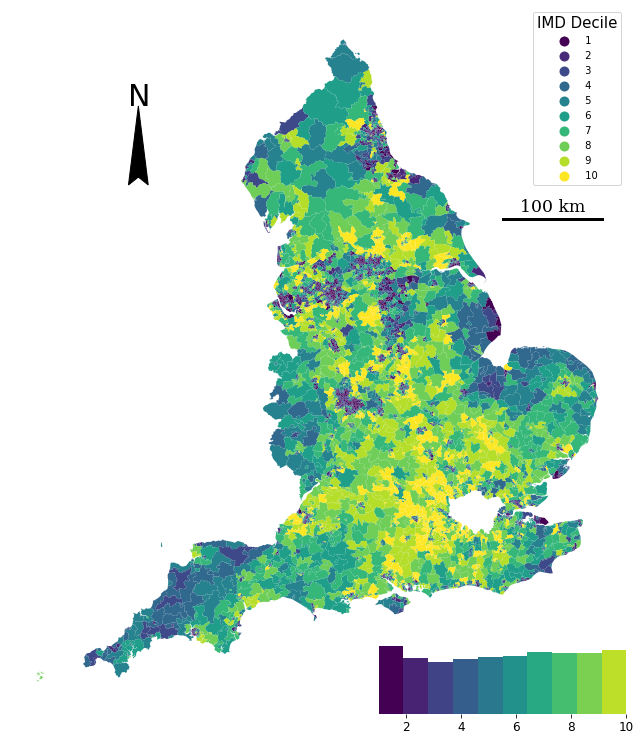

In [32]:
imd_break_1('MSOADECILE')
#plt.savefig('figure/IMD_map', dpi=600,bbox_inches='tight')

## Ethnic white map

In [15]:
def ethnic_break_1(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    
    fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    #ax.set_title('England White Ethnic Percentage by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Percentage")
    ax.get_legend().get_title().set_fontsize('15')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)

    q = mc.NaturalBreaks(fca[column], k=7)
    legendgram(fig, ax, 
                fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

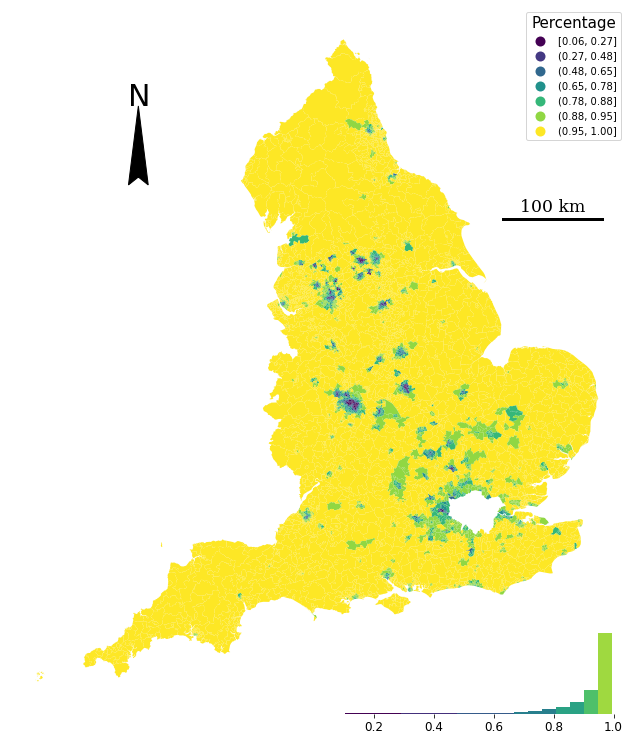

In [16]:
ethnic_break_1("White%")
plt.savefig('figure/White_ethnic_map', dpi=600,bbox_inches='tight')

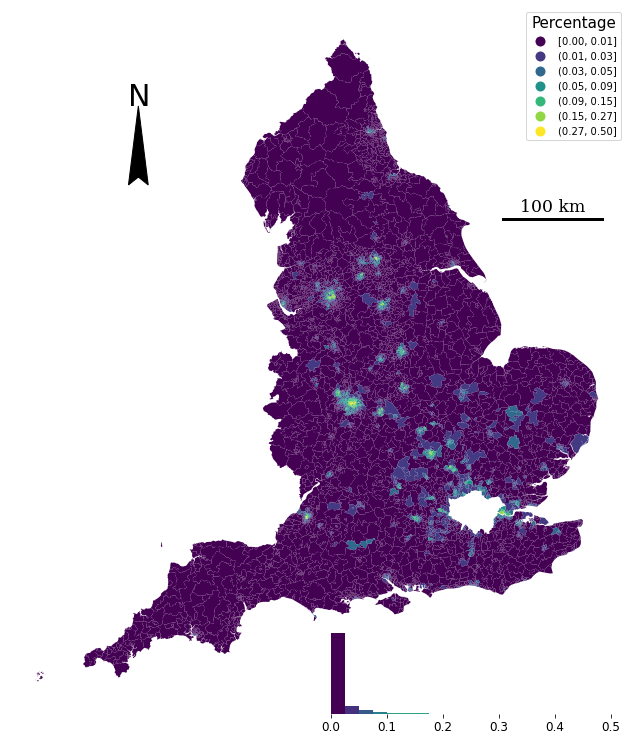

In [17]:
ethnic_break_1("Black%")
plt.savefig('figure/Black_ethnic_map', dpi=600,bbox_inches='tight')

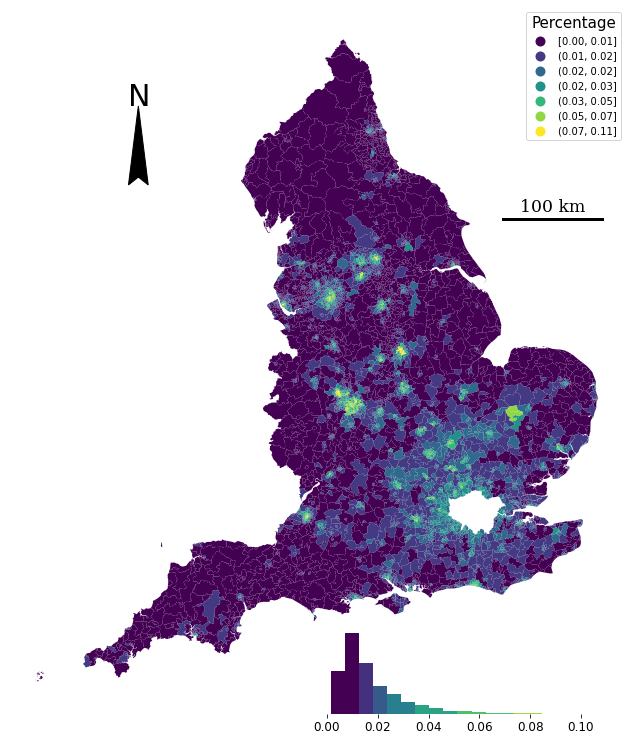

In [18]:
ethnic_break_1("Mixed%")
plt.savefig('figure/Mixed_ethnic_map', dpi=600,bbox_inches='tight')

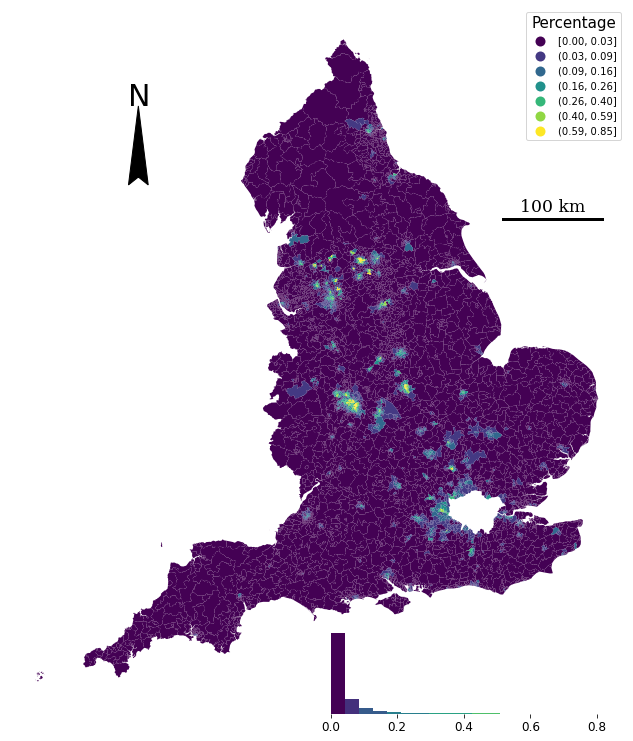

In [19]:
ethnic_break_1("Asian%")
plt.savefig('figure/Asian_ethnic_map', dpi=600,bbox_inches='tight')

### Count the MSOA that the Asian/White/Black/Mixed/Other ethnic group population is over 50%.

In [22]:
print("There are",fca[fca["Asian%"]>0.5].shape[0],"MSOAs that the Asian ethnic population account for over 50% of the population.")
print("There are",fca[fca["White%"]>0.5].shape[0],"MSOAs that the White ethnic population account for over 50% of the population.")
print("There are",fca[fca["Black%"]>0.5].shape[0],"MSOAs that the Black ethnic population account for over 50% of the population.")
print("There are",fca[fca["Mixed%"]>0.5].shape[0],"MSOAs that the Mixed ethnic population account for over 50% of the population.")
print("There are",fca[fca["Other%"]>0.5].shape[0],"MSOAs that the Other ethnic population account for over 50% of the population.")

There are 89 MSOAs that the Asian ethnic population account for over 50% of the population.
There are 5638 MSOAs that the White ethnic population account for over 50% of the population.
There are 1 MSOAs that the Black ethnic population account for over 50% of the population.
There are 0 MSOAs that the Mixed ethnic population account for over 50% of the population.
There are 0 MSOAs that the Other ethnic population account for over 50% of the population.


### Count the MSOA that Asian/White/Black/Mixed/Other ethnic group is the domain ethnic group

In [25]:
White_domain = 0
Mixed_domain = 0
Black_domain = 0
Asian_domain = 0
Other_domain = 0

for index, row in fca.iterrows():
    if max(row["Asian%"],row["White%"],row["Black%"],row["Mixed%"],row['Other%'])==row["Asian%"]:
        Asian_domain+=1
    elif max(row["Asian%"],row["White%"],row["Black%"],row["Mixed%"],row['Other%'])==row["White%"]:
        White_domain+=1
    elif max(row["Asian%"],row["White%"],row["Black%"],row["Mixed%"],row['Other%'])==row["Black%"]:
        Black_domain+=1
    elif max(row["Asian%"],row["White%"],row["Black%"],row["Mixed%"],row['Other%'])==row["Mixed%"]:
        Mixed_domain+=1
    else:
        Other_domain+=1
print("White domain MSOA number:", White_domain)
print("Mixed domain MSOA number:", Mixed_domain)
print("Black domain MSOA number:", Black_domain)
print("Asian domain MSOA number:", Asian_domain)
print("Other domain MSOA number:", Other_domain)

White domain MSOA number: 5684
Mixed domain MSOA number: 0
Black domain MSOA number: 5
Asian domain MSOA number: 119
Other domain MSOA number: 0


## Car hold map

In [27]:
def car_break_1(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    
    fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    #ax.set_title('England Household percentage with at least one car by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Percentage")
    ax.get_legend().get_title().set_fontsize('15')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)

    q = mc.NaturalBreaks(fca[column], k=7)
    legendgram(fig, ax, 
                fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

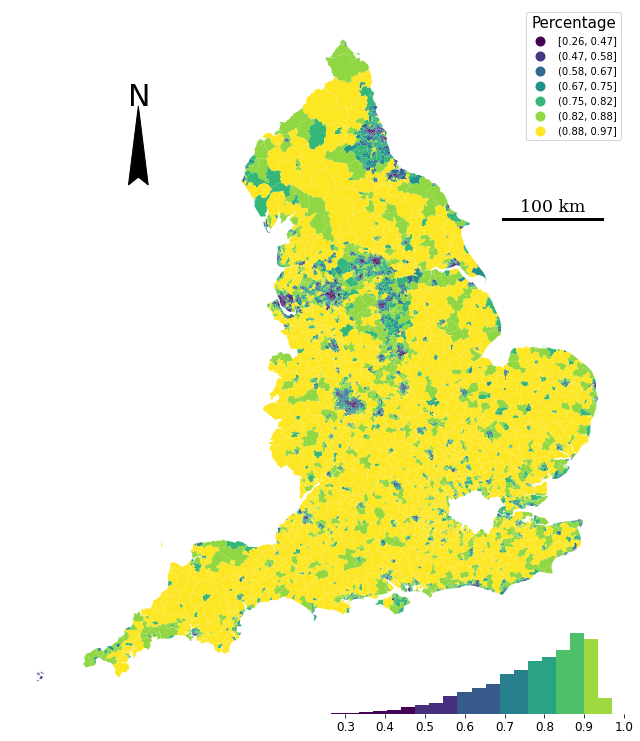

In [28]:
car_break_1("Per_cent_of_households_with_at_least_one_car_or_van")
plt.savefig('figure/Car_percentage_map', dpi=600,bbox_inches='tight')

In [20]:
# Find the percentage of MOSA where car ownership percentage is over 50%
print(fca[fca['Per_cent_of_households_with_at_least_one_car_or_van']>0.5].shape[0]/5808*100,"% of the MSOAs where over half of the households own at least one car")
print(fca[fca['Per_cent_of_households_with_at_least_one_car_or_van']<0.3].shape[0]," of the MSOAs where the car ownership is less than 30%")

96.02272727272727 % of the MSOAs where over half of the households own at least one car
7  of the MSOAs where the car ownership is less than 30%
